In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

In [ ]:
#load the provided dataset into a dataframe
df = pd.read_csv('mnist_train.csv')

In [ ]:
#Convert the data given in the data frame into a NumPy array
data = np.array(df)

In [ ]:
#Shape of the array
shape_A= data.shape
rows = shape_A[0]
columns = shape_A[1]

In [ ]:
#Shuffle the contents of the array
np.random.shuffle(data)
S_df= pd.DataFrame(data)

In [16]:
from keras.datasets import mnist

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Count the occurrences of each class
class_counts = np.bincount(train_labels)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_counts, tick_label=range(10))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in MNIST Dataset')

plt.show()

In [ ]:
#Use the first 1000 images of the dataset as the test set
test_data= data[0:2000]
#Take the remaining rows as the train set
train_data =data[2000:]

#Split the train and test data and X and Y label
X_train= train_data.T
Y_train= X_train[0]
X_train=X_train[1:,:]

x_test = test_data.T
y_test = x_test[0]
x_test = x_test[1:,:]

In [ ]:
#Take the remaining rows as the features of the train set and Normalize the features
X_train = X_train/255
#Normalize the features values by dividing by 255
x_test =  x_test/255

In [ ]:
def initialize_w_b():
    np.random.seed(42)
    B1= np.zeros((200,1))
    R1= np.random.uniform(low=-0.5, high = 0.5, size = (200,784))
    B2= np.zeros((20,1))
    R2= np.random.uniform(low=-0.5, high = 0.5, size = (20,200))
    B3= np.zeros((10,1))
    R3= np.random.uniform(low=-0.5, high = 0.5, size = (10,20))
    return R1,R2,R3,B1,B2,B3

In [ ]:
def kaiming_initialize_w_b():
    
    # Initialize biases
    np.random.seed(51)
    B1 = np.zeros((200, 1))
    B2 = np.zeros((20, 1))
    B3 = np.zeros((10, 1))
    
    # Kaiming initialization for weights
    R1 = np.random.randn(200, 784) * np.sqrt(2 / 784)
    R2 = np.random.randn(20, 200) * np.sqrt(2 / 200)
    R3 = np.random.randn(10, 20) * np.sqrt(2 / 20)
    
    return R1, R2, R3, B1, B2, B3

In [ ]:
def LeakyRelu(Z,alpha):
    """
    Compute the Leaky ReLU activation.

    Arguments:
    Z -- The linear output of a layer before applying the activation function.
    alpha -- Slope of the negative part of the function (usually a small positive value).

    Returns:
    A -- The Leaky ReLU activation of Z.
    """
    A = np.maximum(alpha * Z, Z)
    return A

In [ ]:
def dRelu(Z,alpha):
    dZ = np.ones_like(Z)
    dZ[Z < 0] = alpha
    return dZ

In [ ]:
def tanh(x):
    """
    Compute hyperbolic tangent (tanh) activation for a given input.

    Arguments:
    x -- Input value or array.

    Returns:
    tanh_value -- Tanh activation value(s).
    """
    tanh_value = np.tanh(x)
    return tanh_value

In [ ]:
def tanh_derivative(x):
    """
    Compute the derivative of hyperbolic tangent (tanh) function for a given input.

    Arguments:
    x -- Input value or array.

    Returns:
    tanh_derivative_value -- Derivative of tanh activation value(s).
    """
    tanh_derivative_value = 1 - np.tanh(x)**2
    return tanh_derivative_value

In [ ]:
def sigmoid(x):
    sigmoid_value = 1 / (1 + np.exp(-x))
    return sigmoid_value

In [ ]:
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
def softmax_derivative(z):
    # Calculate the softmax function
    exp_z = np.exp(z)
    softmax = exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    # Calculate the derivative of softmax
    derivative = softmax * (1 - softmax)
    
    return derivative

In [ ]:
def forward_propagation(X,W_1,B_1,W_2,B_2,W3,B3,alpha):
    Z_1 = np.dot(W_1,X)+ B_1
    A1  = LeakyRelu(Z_1,alpha)
    Z_2 = np.dot(W_2,A1)+ B_2
    A2  = tanh(Z_2)
    Z3 = np.dot(W3, A2) +  B3
    A3 = softmax(Z3)
    return Z_1,A1,Z_2,A2,Z3,A3

In [ ]:
def one_hot_encoding(Y_train, num_classes):
    num_samples = len(Y_train)
    one_hot_matrix = np.zeros((num_samples, num_classes))

    for i in range(num_samples):
        class_index = int(Y_train[i])
        one_hot_matrix[i,class_index] = 1

    return one_hot_matrix

In [ ]:
def backward_propagation(Z1, A1, Z2, A2, Z3,A3,W1,W2,W3, X_train, Y_train, alpha,lambda_reg=0.01):
    m = X_train.shape[1]  # Number of samples
    #A3= np.clip(A3,1e-9,1-1e-9)
    dZ3 = A3 - Y_train
    dW3 = (1 / m) * np.dot(dZ3, A2.T)+ (lambda_reg / m) * W3  # L2 regularization term added
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    
    dZ2 = np.dot(W3.T,dZ3) *tanh_derivative(Z2) 
    dW2 = (1 / m) * np.dot(dZ2, A1.T)+ (lambda_reg / m) * W2  # L2 regularization term added
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.dot(W2.T,dZ2) *dRelu(Z1,alpha) 
    dW1 = (1 / m) * np.dot(dZ1,X_train.T)+ (lambda_reg / m) * W1  # L2 regularization term added
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    
    

    return dW1, db1, dW2, db2,dW3,db3

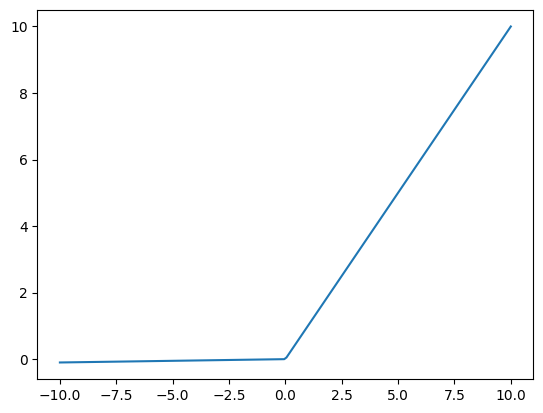

In [ ]:
numbers = np.linspace(-10, 10, 200)
plt.plot(numbers,LeakyRelu(numbers,.01))
plt.show()

In [ ]:
def update_parameters(W1, b1, W2, b2,W3,b3, dW1, db1, dW2, db2,dW3,db3, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3

    return W1, b1, W2, b2,W3,b3

In [ ]:
def calculate_accuracy(predictions, Y_train):
    num_samples = Y_train.shape[1]
    actual_labels = np.argmax(Y_train, axis=0)
    num_correct = np.sum(predictions == actual_labels)
    accuracy = num_correct / num_samples
    return accuracy

In [ ]:
predicted_labels = np.argmax(Y_train, axis=0)
predicted_labels.shape

()

In [ ]:
def gradient_descent(X_train, Y_train, learning_rate, num_iterations):
    num_features = X_train.shape[0]
    num_samples = X_train.shape[1]
    num_classes = Y_train.shape[0]

    W1,W2,W3,b1,b2,b3 = initialize_w_b()  #kaiming_initialize_w_b()
    accuracy_scores = []

    for i in range(num_iterations):
        # Forward Propagation
        Z1, A1, Z2, A2,Z3,A3 = forward_propagation(X_train, W1, b1, W2, b2,W3,b3,learning_rate)
        #print(A3)
        # Backward Propagation
        dW1, db1, dW2, db2,dW3,db3 = backward_propagation(Z1, A1, Z2, A2, Z3 , A3,W1,W2,W3, X_train, Y_train,learning_rate)
        #print(dW1)
        # Update Parameters
        W1, b1, W2, b2, W3, b3  = update_parameters(W1, b1, W2, b2,W3,b3, dW1, db1, dW2, db2,dW3,db3, learning_rate)
        
        # Calculate Accuracy
        if i % 5 == 0:
            A3_reshaped = A3.T
            predictions = get_predictions(A3_reshaped)
            accuracy = calculate_accuracy(predictions, Y_train)
            accuracy_scores.append((i, accuracy))
            #print(W2)
            print(f"Iteration {i}, Accuracy: {accuracy}")

    return W1, b1, W2, b2,W3,b3, accuracy_scores

In [ ]:
A3_reshaped = A3.T
predictions = get_predictions(A3_reshaped)

In [ ]:
Z1, A1, Z2, A2,Z3, A3 = forward_propagation(x_test,W1, b1, W2, b2,W3,b3,learning_rate) 

In [ ]:
num_samples = y_test.shape[1]
actual_labels = np.argmax(y_test, axis=0)
num_correct = np.sum(predictions == actual_labels)
accuracy = num_correct / num_samples

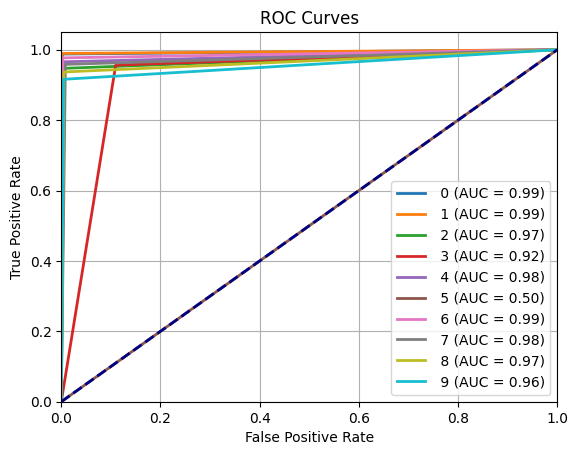

In [ ]:
# Convert predicted scores to one-hot encoded probabilities
num_classes = len(np.unique(actual_labels))
predicted_probabilities = np.zeros((len(actual_labels), num_classes))
predicted_probabilities[np.arange(len(actual_labels)), predictions] = 1

# Compute ROC curves for each class
plt.figure()
for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve((actual_labels == class_index).astype(int), predicted_probabilities[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f' {class_index} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
#plt.savefig('ROCRandominiL2xx60k')
plt.show()

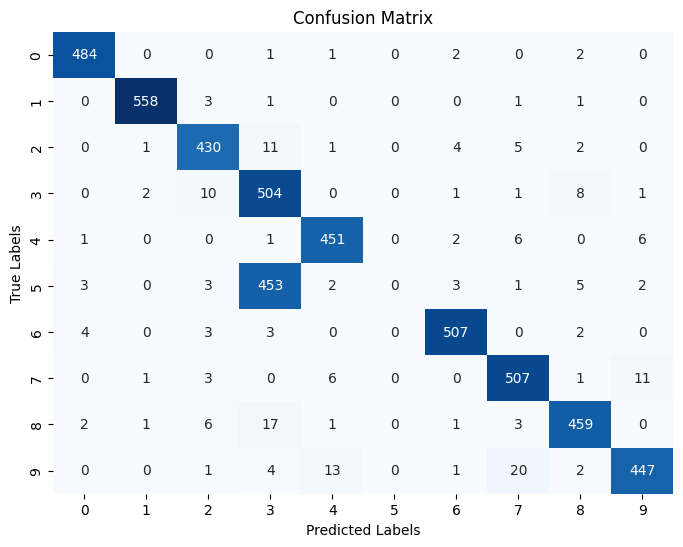

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
#plt.savefig('ConfusionMatrixRandominiL2xx60k')
plt.show() 

In [ ]:
def get_predictions(output_vector):
    max_index = np.argmax(output_vector, axis=1)
    return max_index

In [ ]:
def make_prediction(test_vector, W1, b1, W2, b2,W3,b3, index,alpha):
    # Assuming you have functions to preprocess test_vector if needed
    num_classes= b3.shape[0]
    # Forward Propagation
    Z1, A1, Z2, A2,Z3,A3  = forward_propagation(test_vector, W1, b1, W2, b2,W3,b3,alpha)

    # Obtain Predictions
    A3_reshaped = A3.T
    predictions = get_predictions(A3_reshaped)

    return predictions

In [ ]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y_test = np.array(one_hot_encoding(y_test, num_classes))

y_test= y_test.T

Y_train = np.array(one_hot_encoding(Y_train, num_classes))

Y_train= Y_train.T

In [ ]:
def test_prediction(index, W1, b1, W2, b2,W3,b3, x_test, y_test,alpha):
    # Retrieve the test image based on the index
    test_image = x_test.T[index]

    # Make a prediction using the make_prediction function
    prediction = make_prediction(x_test, W1, b1, W2, b2,W3,b3,index,alpha)

    # Find the actual label from the ground truth Y_train vector
    actual_label = np.argmax(y_test.T[index])

    # Reshape and plot the test image
    plt.imshow(test_image.reshape((28, 28)), cmap='gray')  # Assuming MNIST-like 28x28 images
    plt.title(f"Predicted: {prediction[index]}, Actual: {actual_label}")
    plt.axis('off')
    plt.savefig('preditions fig7')
    plt.show()

In [ ]:
num_classes= 10
learning_rate= 0.09
num_iterations =5000

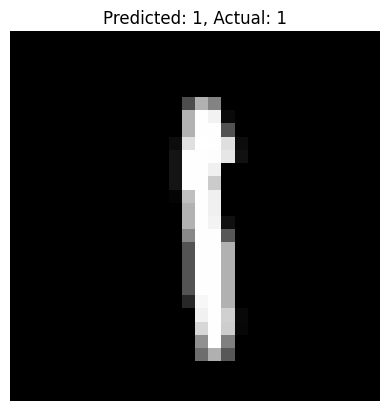

In [ ]:
test_prediction(3, W1, b1, W2, b2, W3, b3, x_test, y_test,learning_rate)

In [ ]:
W1, b1, W2, b2,W3,b3, accuracy_scores = gradient_descent(X_train, Y_train, learning_rate, num_iterations)

Iteration 0, Accuracy: 0.10386206896551724
Iteration 5, Accuracy: 0.1528448275862069
Iteration 10, Accuracy: 0.1899655172413793
Iteration 15, Accuracy: 0.22375862068965519
Iteration 20, Accuracy: 0.24879310344827585
Iteration 25, Accuracy: 0.2689655172413793
Iteration 30, Accuracy: 0.2812586206896552
Iteration 35, Accuracy: 0.29594827586206895
Iteration 40, Accuracy: 0.3102241379310345
Iteration 45, Accuracy: 0.3248448275862069
Iteration 50, Accuracy: 0.3406206896551724
Iteration 55, Accuracy: 0.3611896551724138
Iteration 60, Accuracy: 0.38932758620689656
Iteration 65, Accuracy: 0.41101724137931034
Iteration 70, Accuracy: 0.42632758620689654
Iteration 75, Accuracy: 0.43810344827586206
Iteration 80, Accuracy: 0.4483448275862069
Iteration 85, Accuracy: 0.45663793103448275
Iteration 90, Accuracy: 0.4645344827586207
Iteration 95, Accuracy: 0.4708103448275862
Iteration 100, Accuracy: 0.4766896551724138
Iteration 105, Accuracy: 0.48279310344827586
Iteration 110, Accuracy: 0.4876896551724138


KeyboardInterrupt: 

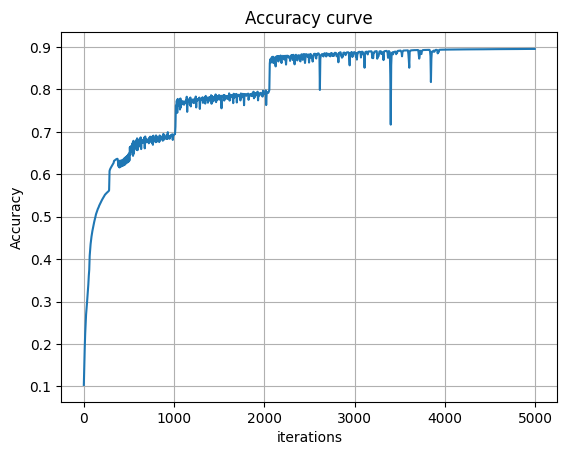

In [ ]:
x_value= np.array(accuracy_scores).T[0]
y_value= np.array(accuracy_scores).T[1]

plt.plot(x_value, y_value)
plt.title("Accuracy curve")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.grid(True)
#plt.savefig("AccuracycurverandominiL2xx60k")
plt.show()